# Occupancy Grid PseudoCode

We first need to convert the actor_state_tensor to a more usable format, the information that we need should be stored into a dictionary like this:
```
{
    walls: [
        {pos_x: 0,
        pos_y: 0,
        width: 1,
        height: 10,
        theta: 0}, 
        ...
    ], 
    obstacles: [
        {pos_x: 0,
        pos_y: 0,
        width: 1,
        height: 1,
        theta: 0.32},
        ...
    ]
    robot: [
        {pos_x: 0, 
        pos_y: 0,
        width: 1, 
        height: 1, 
        theta: 2.5}
    ]
}
```

Given an object's `pos_x`, `pos_y`, `width`, `height`, the upper and lower bound space that the object occupies is:

x: [`pos_x` + `width`/2, `pos_x` - `width`/2] if orientation == 0 else  [`pos_x` + `height`/2, `pos_x` - `height`/2]

y: [`pos_y` + `height`/2, `pos_y` - `height`/2] if orientation == 0 else [`pos_y` + `width`/2, `pos_y` - `width`/2]

Let's assume that every room is the same dimension, and the occupancy grid represents a 10m x 10m space with a n x n grid

In this space we represent each cell with the following notation:
- 0: free space
- 1: wall
- 2: obstacle
- 3: robot

> Let's approach from the perspective that each object needs to be represented on the grid:

### Naive approach:
All cells that the x-y bound of the obstacle touches (with threshold > 25% of the grid?) will belong to this object;

Where there multiple objects negotiating for a single cell, we choose the object with the largest area present

should work if object size << grid size



### Approach with parameter $\theta$

Given an object's `pos_x`, `pos_y`, `width`, `height`, `theta`, we can derive the following four lines bounding the rectangular object:

"top" and "bottom" bounds:
$$
y = -\frac{1}{\tan(\theta)}x \pm \frac{h}{2}\frac{1}{\cos(\theta)}
$$

"right" and "left" bounds:
$$
y = \tan(\theta)x \pm \frac{w}{2}\frac{1}{\sin(\theta)}
$$

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

In [9]:
def get_vertices(obj_state, obj_vertices, obj_rot_vertices, room_size=10, n=64):
    w = obj_state[:, :, 2] * (n/room_size)
    h = obj_state[:, :, 3] * (n/room_size)
    d = ((w/2)**2 + (h/2)**2)**0.5
    num_obj = obj_state.shape[1]

    # only these need to be updated - object shape doesn't change
    x_pos = obj_state[:, :, 0] * (n/room_size)
    y_pos = obj_state[:, :, 1] * (n/room_size)
    theta = obj_state[:, :, 4]

    obj_vertices[:, :, 0, 0] = np.sin(np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 0, 1] = np.cos(np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 1, 0] = np.sin(
        np.pi - np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 1, 1] = np.cos(
        np.pi - np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 2, 0] = np.sin(
        np.pi + np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 2, 1] = np.cos(
        np.pi + np.arctan(w/h) + theta) * d + y_pos
    obj_vertices[:, :, 3, 0] = np.sin(-np.arctan(w/h) + theta) * d + x_pos
    obj_vertices[:, :, 3, 1] = np.cos(-np.arctan(w/h) + theta) * d + y_pos

    obj_rot_vertices[:, :, 1, :] = obj_vertices[:, :, 0, :]
    obj_rot_vertices[:, :, 2, :] = obj_vertices[:, :, 1, :]
    obj_rot_vertices[:, :, 3, :] = obj_vertices[:, :, 2, :]
    obj_rot_vertices[:, :, 0, :] = obj_vertices[:, :, 3, :]

    return obj_vertices.view(-1, 1, 1, num_obj*4, 2), obj_rot_vertices.view(-1, 1, 1, num_obj*4, 2)


def get_occ_cells(Px, Py, vertices, rotated_vertices):

    n = Py.shape[1]
    num_envs = Py.shape[0]
    b = vertices - rotated_vertices

    out = torch.where(torch.mul(torch.sub(Px, vertices[:, :, :, :, 0]), b[:, :, :, :, 1]) -
                      torch.mul(torch.sub(Py, vertices[:, :, :, :, 1]), b[:, :, :, :, 0]) <= 0, 0, 1)

    mask = torch.zeros((num_envs, n, n))
    i = 0
    while i < out.shape[-1]:
        temp_mask = torch.ones((num_envs, n, n))
        for j in range(4):
            temp_mask = torch.mul(temp_mask, out[:, :, :, i+j])
        # overwrite to mask
        mask = torch.where(temp_mask != 0, torch.ones_like(mask), mask)
        i += 4

    return mask


In [18]:
num_envs = 4096

n = 64
walls = torch.tensor([[-1.6+5, 0+5, 8, 0.25, np.pi/2],
                      [1.6+5, 0+5, 8, 0.25, np.pi/2],
                      [0+5, 4+5, 3.2, 0.25, 0],
                      [0+5, -4+5, 3.2, 0.25, 0],
                      ]).unsqueeze(0).repeat(num_envs, 1, 1)
boxes = torch.tensor([[-0.76+5, 0+5, 1, 1, random.random()*np.pi],
                      [0.76+5, 0+5, 1, 1, random.random()*np.pi],
                      ]).unsqueeze(0).repeat(num_envs, 1, 1)
summit = torch.tensor([[0+5, 3+5, 0.98, 0.78, np.pi/2],
                       ]).unsqueeze(0).repeat(num_envs, 1, 1)

num_walls = walls.shape[1]
num_boxes = boxes.shape[1]
num_summit = 1

walls_vertices = torch.zeros(num_envs, num_walls, 4, 2)
rotated_walls_vertices = torch.zeros_like(walls_vertices)
walls_vertices, rotated_walls_vertices = get_vertices(
    walls, walls_vertices, rotated_walls_vertices, n=n)

boxes_vertices = torch.zeros(num_envs, num_boxes, 4, 2)
rotated_boxes_vertices = torch.zeros_like(boxes_vertices)
boxes_vertices, rotated_boxes_vertices = get_vertices(
    boxes, boxes_vertices, rotated_boxes_vertices, n=n)

summit_vertices = torch.zeros(num_envs, num_summit, 4, 2)
rotated_summit_vertices = torch.zeros_like(summit_vertices)
summit_vertices, rotated_summit_vertices = get_vertices(
    summit, summit_vertices, rotated_summit_vertices, n=n)


In [19]:
Px_walls = torch.tensor(list(range(n))).unsqueeze(
    dim=-1).unsqueeze(dim=-1).repeat(num_envs, 1, 1, num_walls*4)
Py_walls = torch.transpose(Px_walls, 1, 2)
walls_grid = get_occ_cells(Py_walls, Px_walls, walls_vertices, rotated_walls_vertices)

Px_boxes = torch.tensor(list(range(n))).unsqueeze(
    dim=-1).unsqueeze(dim=-1).repeat(num_envs, 1, 1, num_boxes*4)
Py_boxes = torch.transpose(Px_boxes, 1, 2)
boxes_grid = get_occ_cells(Py_boxes, Px_boxes, boxes_vertices, rotated_boxes_vertices)

Px_summit = torch.tensor(list(range(n))).unsqueeze(
    dim=-1).unsqueeze(dim=-1).repeat(num_envs, 1, 1, num_summit*4)
Py_summit = torch.transpose(Px_summit, 1, 2)
summit_grid = get_occ_cells(Py_summit, Px_summit, summit_vertices, rotated_summit_vertices)


In [20]:
occ_grid = boxes_grid * 2
occ_grid = torch.where(summit_grid > 0, summit_grid * 3, occ_grid)
occ_grid = torch.where(walls_grid > 0, walls_grid, occ_grid)

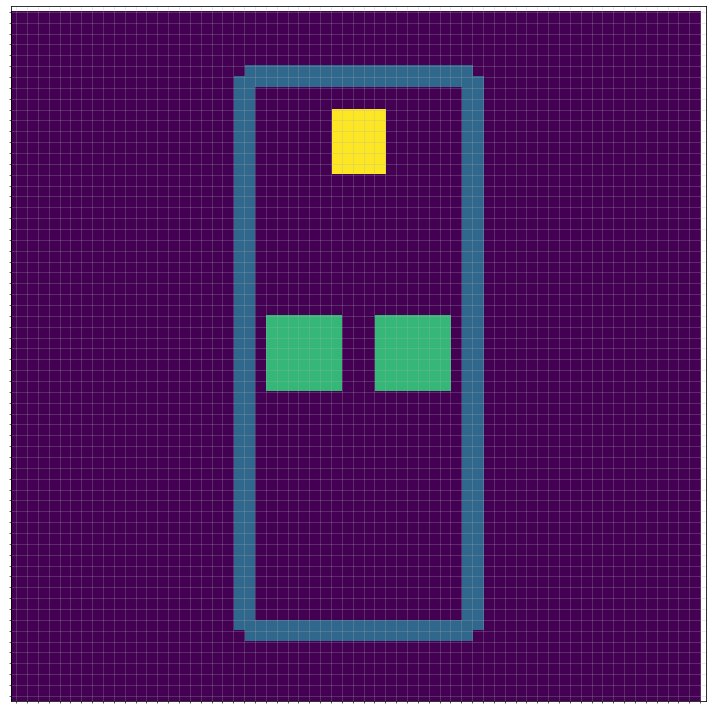

In [21]:
# plot rasterized rectangle
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ticks = np.linspace(0.5, n-0.5, n)
ax.set_xticks(ticks, minor=True)
ax.set_yticks(ticks, minor=True)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.grid(which='minor', alpha=0.3)

ax.imshow(occ_grid[0])

plt.xlim(0, n)
plt.ylim(0, n)
plt.tight_layout()
